# Versão 3.1 - Iteração buscando métricas ainda melhores

Os resultados obtidos foram satisfatórios, mas ainda existem muito espaços para melhoras. Um banco nunca aceitaria um modelo com 30% de risco de inadimplência. Portanto, novas iterações serão feitas buscando melhorar as métricas, como:
1. Engenharia de Atributos
2. Evolução do balanceamento - Mudar o SMOTE para SMOTE-Tomek
3. Testar novos modelos (CatBoost, Voting Classifier)
4. Otimização focada em negócio (Custo do Erro)

1. Importando bibliotecas necessárias

In [1]:
# Manipulação de dados e matemática

import pandas as pd
import numpy as np

# Visualização gráfica

import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento e escalonamento

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Balanceamento de Dados (Imbalanced-Learn)

from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

# Modelos de Machine Learning
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Métricas de Avaliação
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    precision_score,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    classification_report,
    fbeta_score,
    make_scorer,
    f1_score
)


# Exportação do Modelo
import joblib

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# 1. Ignorar avisos de mudanças futuras (FutureWarnings)
warnings.simplefilter(action='ignore', category=FutureWarning)

# 2. Ignorar avisos de inconsistências de parâmetros (UserWarnings)
warnings.simplefilter(action='ignore', category=UserWarning)

# 3. Ignorar avisos quando o modelo não atinge a convergência (ConvergenceWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

2. Importando o dataframe processado do notebook 2

In [3]:
df = pd.read_parquet('../data/dados_credito_processados.parquet')

df.head()

,idade,sexo_num,valor_conta_poupanca,valor_conta_corrente,salario_anual,valor_emprestimo,prazo_meses,status_inadimplencia,fin_business,fin_car,fin_domestic appliances,fin_education,fin_furniture/equipment,fin_radio/TV,fin_repairs,fin_vacation/others,moradia_free,moradia_own,moradia_rent,comprometimento_renda
0,64.5,1,0.00,30047.52,71436.17,1169.0,6,0,0,0,0,0,0,1,0,0,0,1,0,0.016364
1,22.0,0,93.08,55717.96,49750.60,5951.0,42,1,0,0,0,0,0,1,0,0,0,1,0,0.119617
2,49.0,1,437.57,0.00,30094.48,2096.0,12,0,0,0,0,1,0,0,0,0,0,1,0,0.069647
3,45.0,1,908.93,35947.88,52983.38,7882.0,42,0,0,0,0,0,1,0,0,0,1,0,0,0.148764
4,53.0,1,775.27,33274.01,55310.09,4870.0,24,1,0,1,0,0,0,0,0,0,1,0,0,0.088049


3. Engenharia de Atributos Avançada:

Antes de fazer o procedimento comum de criação de pipelines e treinamentos, vamos fazer uma análise exploratória mais aprofundada, utilizando da engenharia de atributos para buscar métricas melhores.

Para isso, iremos criar as seguintes novas features:
1. Parcela Mensal Estimada
2. Renda Livre Mensal
3. Índice de Cobertura de Liquidez
4. Booleana de Conta Zerada

In [4]:
# Parcela Mensal Estimada

df['parcela_mensal_estimada'] = df['valor_emprestimo']/df['prazo_meses']

# Renda Livre Mensal

df['renda_livre_mensal'] = df['salario_anual']/12 - df['parcela_mensal_estimada']

# Índice de Cobertura de Liquidez

df['cobertura_liquidez'] = (df['valor_conta_corrente'] + df['valor_conta_poupanca']) / (df['parcela_mensal_estimada']+ 0.01)

# Booleana de Conta Zerada

df['is_conta_corrente_zero'] = (df['valor_conta_corrente'] == 0).astype(int)

# Comprometimento Renda

df['comprometimento_renda'] = df['parcela_mensal_estimada'] / (df['salario_anual'] / 12).replace(0, 1)



In [5]:
df.head()

,idade,sexo_num,valor_conta_poupanca,valor_conta_corrente,salario_anual,valor_emprestimo,prazo_meses,status_inadimplencia,fin_business,fin_car,...,fin_repairs,fin_vacation/others,moradia_free,moradia_own,moradia_rent,comprometimento_renda,parcela_mensal_estimada,renda_livre_mensal,cobertura_liquidez,is_conta_corrente_zero
0,64.5,1,0.00,30047.52,71436.17,1169.0,6,0,0,0,...,0,0,0,1,0,0.032729,194.833333,5758.180833,154.213744,0
1,22.0,0,93.08,55717.96,49750.60,5951.0,42,1,0,0,...,0,0,0,1,0,0.034176,141.690476,4004.192857,393.866284,0
2,49.0,1,437.57,0.00,30094.48,2096.0,12,0,0,0,...,0,0,0,1,0,0.069647,174.666667,2333.206667,2.505028,1
3,45.0,1,908.93,35947.88,52983.38,7882.0,42,0,0,0,...,0,0,1,0,0,0.042504,187.666667,4227.615000,196.384615,0
4,53.0,1,775.27,33274.01,55310.09,4870.0,24,1,0,1,...,0,0,1,0,0,0.044025,202.916667,4406.257500,167.791058,0


4. Limpeza Robusta e Análise Gráfica Aprofundada

Para proceder, podemos analisar se temos outliers dentro das colunas de valor do empréstimo e saldo da conta corrente e se tivermos, os tratamos antes do pré processamento.

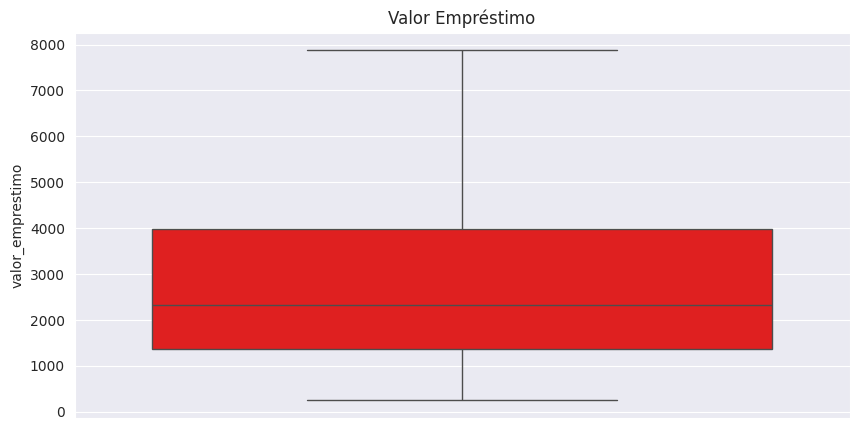

In [6]:
plt.figure(figsize=(10,5))

sns.boxplot(y = df['valor_emprestimo'], color = 'red')
plt.title("Valor Empréstimo")
plt.show()

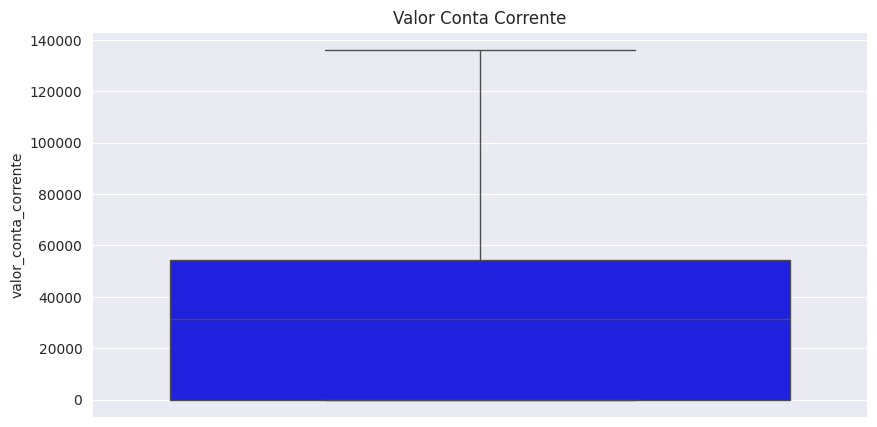

In [7]:
plt.figure(figsize=(10,5))

sns.boxplot(y = df['valor_conta_corrente'], color = 'blue')
plt.title("Valor Conta Corrente")
plt.show()

Através destes gráficos, podemos observar que ambas as colunas estão com assimetrias. Para tratá-las, iremos utilizar a transformação logarítmica presentes no numpy.

In [8]:
colunas = ['valor_emprestimo', 'valor_conta_corrente']

for col in colunas:
    df[f'log_{col}'] = np.log1p(df[col])

df.drop(['valor_emprestimo','valor_conta_corrente' ], axis = 1, inplace = True)
df.head()

,idade,sexo_num,valor_conta_poupanca,salario_anual,prazo_meses,status_inadimplencia,fin_business,fin_car,fin_domestic appliances,fin_education,...,moradia_free,moradia_own,moradia_rent,comprometimento_renda,parcela_mensal_estimada,renda_livre_mensal,cobertura_liquidez,is_conta_corrente_zero,log_valor_emprestimo,log_valor_conta_corrente
0,64.5,1,0.00,71436.17,6,0,0,0,0,0,...,0,1,0,0.032729,194.833333,5758.180833,154.213744,0,7.064759,10.310569
1,22.0,0,93.08,49750.60,42,1,0,0,0,0,...,0,1,0,0.034176,141.690476,4004.192857,393.866284,0,8.691483,10.928076
2,49.0,1,437.57,30094.48,12,0,0,0,0,1,...,0,1,0,0.069647,174.666667,2333.206667,2.505028,1,7.648263,0.000000
3,45.0,1,908.93,52983.38,42,0,0,0,0,0,...,1,0,0,0.042504,187.666667,4227.615000,196.384615,0,8.972464,10.489853
4,53.0,1,775.27,55310.09,24,1,0,1,0,0,...,1,0,0,0.044025,202.916667,4406.257500,167.791058,0,8.491055,10.412562


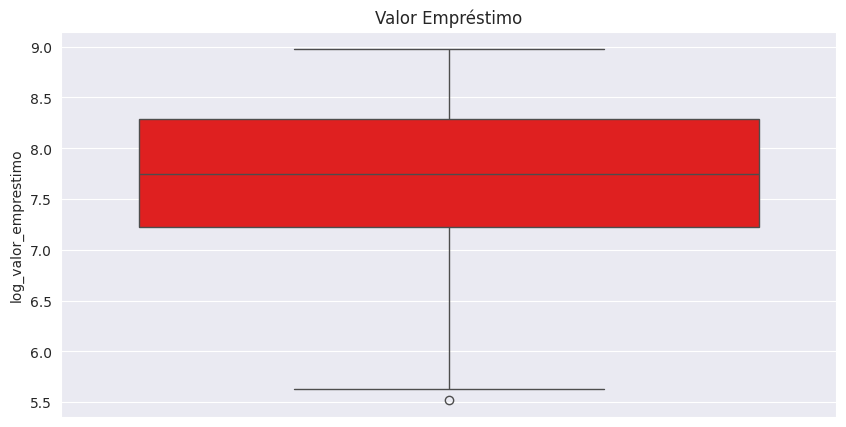

In [9]:
plt.figure(figsize=(10,5))

sns.boxplot(y = df['log_valor_emprestimo'], color = 'red')
plt.title("Valor Empréstimo")
plt.show()

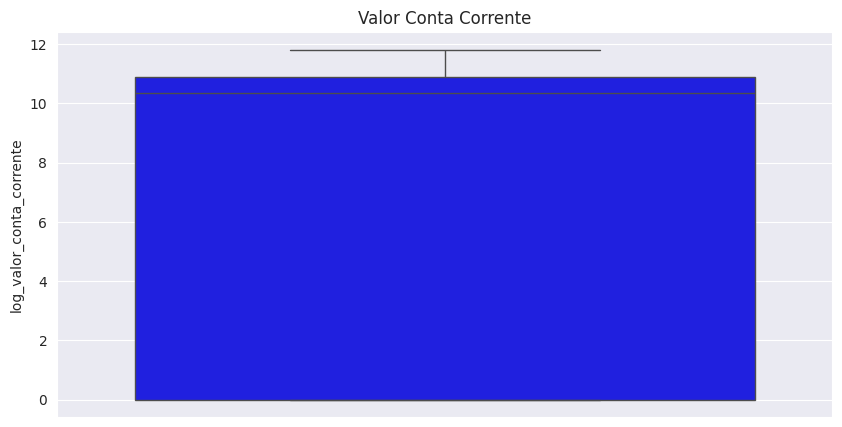

In [10]:
plt.figure(figsize=(10,5))

sns.boxplot(y = df['log_valor_conta_corrente'], color = 'blue')
plt.title("Valor Conta Corrente")
plt.show()

Agora, iremos criar uma matriz de correlação para ver o coeficiente de pearson das colunas e nosso target.

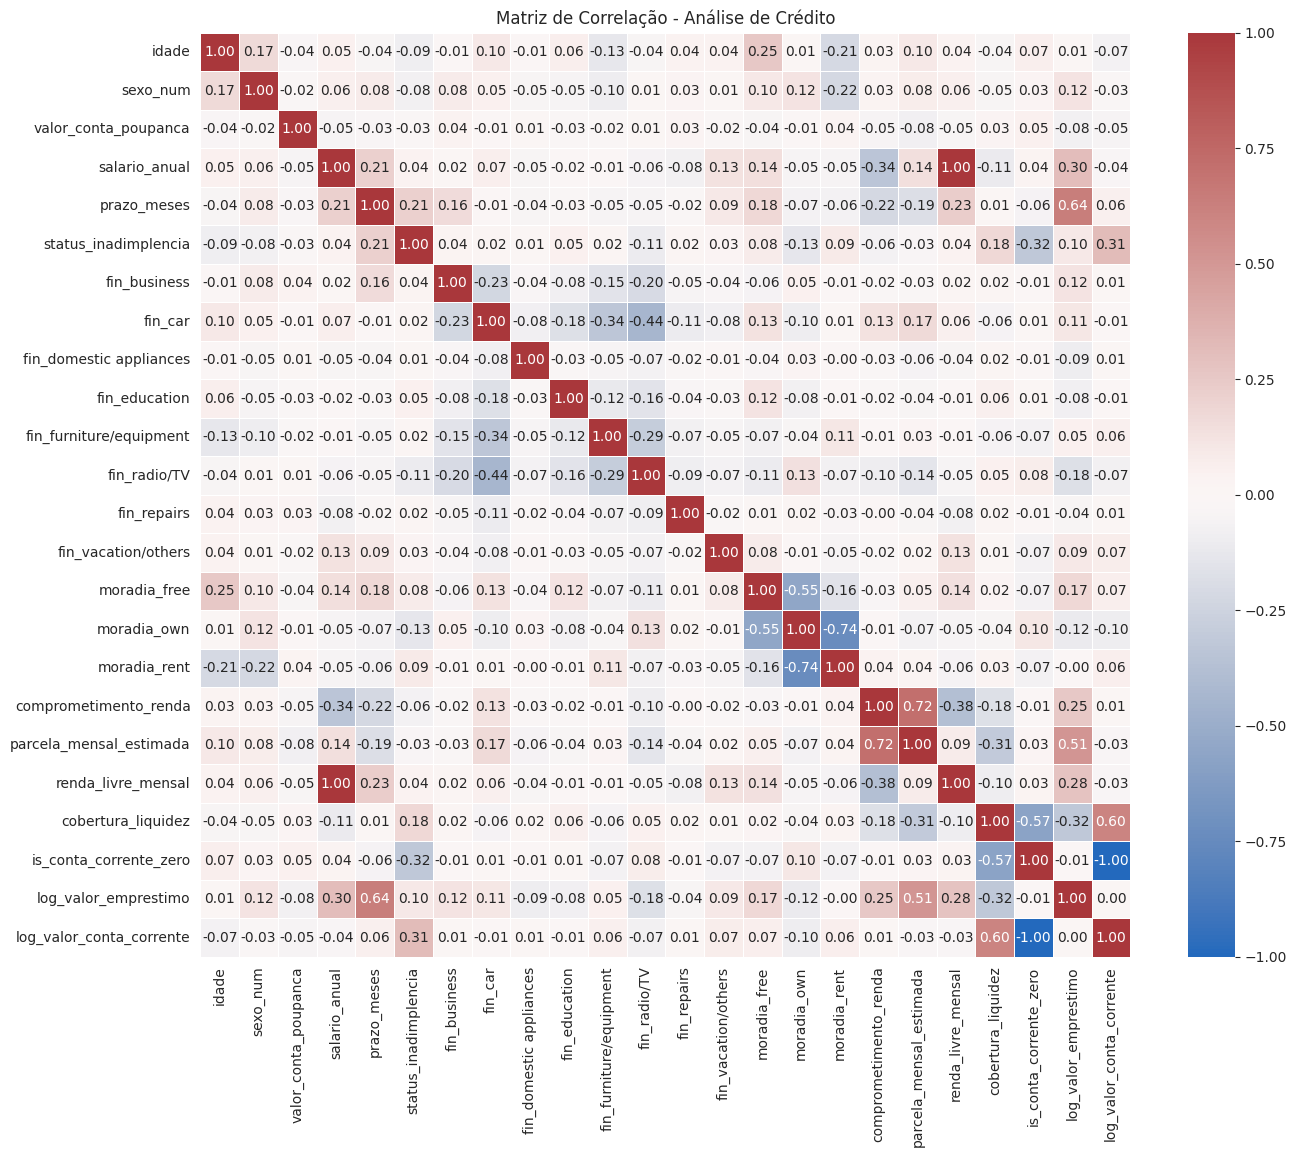

In [11]:
corr = df.corr()

plt.figure(figsize=(15, 12)) # Aumentei o tamanho para caber tudo

# annot=True: Mostra os números
# fmt=".2f": Mostra apenas 2 casas decimais (para não poluir)
# cmap='RdBu': Vermelho (positivo) e Azul (negativo), costuma ser mais nítido que o coolwarm
# vmin=-1, vmax=1: Trava a escala para garantir que o branco seja o zero exato
sns.heatmap(corr, annot=True, fmt=".2f", cmap='vlag', vmin=-1, vmax=1, linewidths=0.5)

plt.title("Matriz de Correlação - Análise de Crédito")
plt.show()

In [1]:
colunas_para_manter = [
    'idade',
    'log_valor_emprestimo',
    'log_valor_conta_corrente',
    'is_conta_corrente_zero',
    'prazo_meses',
    'comprometimento_renda',
    'parcela_mensal_estimada',
    'renda_livre_mensal',
    'cobertura_liquidez',
    'moradia_own',
    'moradia_rent',
    'status_inadimplencia'
]

# removendo o que NÃO está na lista acima

df_limpo = df.drop(columns=df.columns.difference(colunas_para_manter))

# 3. Verificando o resultado
print(f"Colunas restantes: {df_limpo.shape[1]}")
print(df_limpo.columns.tolist())

NameError: name 'df' is not defined

Observando a matriz, podemos perceber que algumas das variáveis novas se apresentam como essenciais para o projeto. Assim, iremos manter apenas elas e mais algumas consideradas essenciais para o treinamento dos modelos de Machine Learning.

Variáveis mais importantes:

* log_valor_conta_corrente
* cobertura_liquidez
* prazo_meses
* moradia_own

5. Criando a Pipeline de Pré-processamento

Dentro da pipeline, iremos utilizar dois parâmetros:
* F1 score: consiste na média harmônica entre a precisão (de todas as vezes que o modelo previu algo como positivo, quantas estavam realmente corretas) e o recall (de todos os casos positivos que realmente existiam, quantos o modelo conseguiu detectar);
* F-beta score: média harmônica ponderada entre precisão e recall. Se beta > 1, o recall tem mais peso e se beta < 1, a precisão tem mais peso.

Por que estes dois parâmetros? O F1 score é a versão padrão, e o F beta score pode ser utilizado para decidir o que é mais importante: evitar falsos alarmes (precisão) ou não deixar um inadimplente escapar (recall). Em sistemas de risco de bancos, é mais comum perder alguns bons pagantes do que aceitar um inadimplente que pode causar R$50.000 de prejuízo.

Neste caso, se o cliente ruim é o que buscamos detectar, queremos MAXIMIZAR o recall, visto que um maior recall significa que ele conseguiu detectar mais clientes inadimplentes. Assim, beta deve ser maior que 1.

O valor de Beta deve ser selecionado considerando quantos clientes bons o banco aceita perder para não aceitar indevidamente um inadimplente. Escolhi o F2​-score (β=2) porque, no setor bancário, o impacto financeiro de um calote (Falso Negativo) é historicamente estimado entre 4 a 5 vezes superior ao custo de oportunidade de recusar um bom cliente (Falso Positivo). Matematicamente,
$$
\beta = \sqrt{\frac{\text{Custo\ do\ Falso\ Negativo\ (FN)}}{\text{Custo\ do\ Falso\ Positivo\ (FP)}}}
$$
 justifica o foco em Recall para proteger a solvência da instituição."


5.1 Separando as colunas variáveis (matriz X) e coluna target (array y)

In [13]:
X = df_limpo.drop(columns = ['status_inadimplencia'])
y = df_limpo['status_inadimplencia']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

5.2 Buscando os melhores hiperparâmetros e os melhores modelos

Iremos selecionar alguns modelos e para cada modelos alguns hiperparâmetros (hyperparameter tuning) através do RandomizedSearchCV. Os modelos escolhidos serão

In [33]:
resultados = []
melhores_modelos = {}

grids = {
    "Logistic Regression": {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga'], # 'saga' é bom para datasets maiores
        'classifier__max_iter': [100, 200]
    },

    "Random Forest": {
        'classifier__n_estimators': [100, 300, 500],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__bootstrap': [True, False]
    },

    "XGBoost": {
        'classifier__n_estimators': [100, 300, 500],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__max_depth': [3, 5, 7],
        'classifier__subsample': [0.6, 0.8, 1.0],
        'classifier__colsample_bytree': [0.6, 0.8, 1.0],
        'classifier__gamma': [0, 0.1, 0.2]
    },

    "HistGB":{
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__max_iter': [100, 200, 300],
        'classifier__max_depth': [3, 5, 10],
        'classifier__l2_regularization': [0, 0.1, 1.0]
    }

}

modelos = {
    'Logistic Regression' : LogisticRegression(max_iter = 1000),
    'Random Forest' : RandomForestClassifier(random_state=42),
    'XGBoost' : XGBClassifier(random_state=42, verbosity=0 ),
    'HistGB': HistGradientBoostingClassifier(random_state=42),
}

scorers = {
    'f1': make_scorer(f1_score),
    'f2': make_scorer(fbeta_score, beta=2)
}

# Verificações antes do treinamento dos modelos
print('Checando NaNs e infinitos em X_train e y_train...')
print('X_train NaNs:', X_train.isnull().sum().sum())
print('X_train infinitos:', np.isinf(X_train).sum().sum())
print('y_train NaNs:', y_train.isnull().sum())
print('y_train valores únicos:', y_train.value_counts().to_dict())

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
print('Distribuição das classes em cada fold:')
for i, (_, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"Fold {i}: {y_train.iloc[val_idx].value_counts().to_dict()}")


for nome, modelo in modelos.items():
    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('smote', SMOTETomek(random_state=42)),
        ('classifier', modelo)
    ])

    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=grids[nome],
        n_iter=10,
        cv=5,
        scoring=scorers,
        refit='f2', # define o melhor modelo com base no f2 e não no f1
        n_jobs=1,
        random_state=42,
        verbose=0
    )

    search.fit(X_train, y_train)

    idx_melhor = search.best_index_
    f1_cv = search.cv_results_['mean_test_f1'][idx_melhor]
    f2_cv = search.cv_results_['mean_test_f2'][idx_melhor]

    melhores_modelos[nome] = search.best_estimator_

    resultados.append({
        'Modelo': nome,
        'Melhor F1 (Treino/CV)': f1_cv,
        "Melhor F2 (Treino/CV)": f2_cv,
        'Melhores Parâmetros': search.best_params_
    })

    print(f"✅ {nome} finalizado. F1-Score: {f1_cv:.4f}")
    print(f"✅ {nome} finalizado. F2-Score: {f2_cv:.4f}")


Checando NaNs e infinitos em X_train e y_train...
X_train NaNs: 0
X_train infinitos: 0
y_train NaNs: 0
y_train valores únicos: {0: 560, 1: 240}
Distribuição das classes em cada fold:
Fold 0: {0: 112, 1: 48}
Fold 1: {0: 112, 1: 48}
Fold 2: {0: 112, 1: 48}
Fold 3: {0: 112, 1: 48}
Fold 4: {0: 112, 1: 48}
✅ Logistic Regression finalizado. F1-Score: 0.5780
✅ Logistic Regression finalizado. F2-Score: 0.6638
✅ Random Forest finalizado. F1-Score: 0.5601
✅ Random Forest finalizado. F2-Score: 0.5805
✅ XGBoost finalizado. F1-Score: 0.5621
✅ XGBoost finalizado. F2-Score: 0.6468
✅ HistGB finalizado. F1-Score: 0.5572
✅ HistGB finalizado. F2-Score: 0.6438


Melhor modelo: Logistic Regression
Melhores parâmetros:
  classifier__solver: liblinear
  classifier__penalty: l1
  classifier__max_iter: 100
  classifier__C: 100


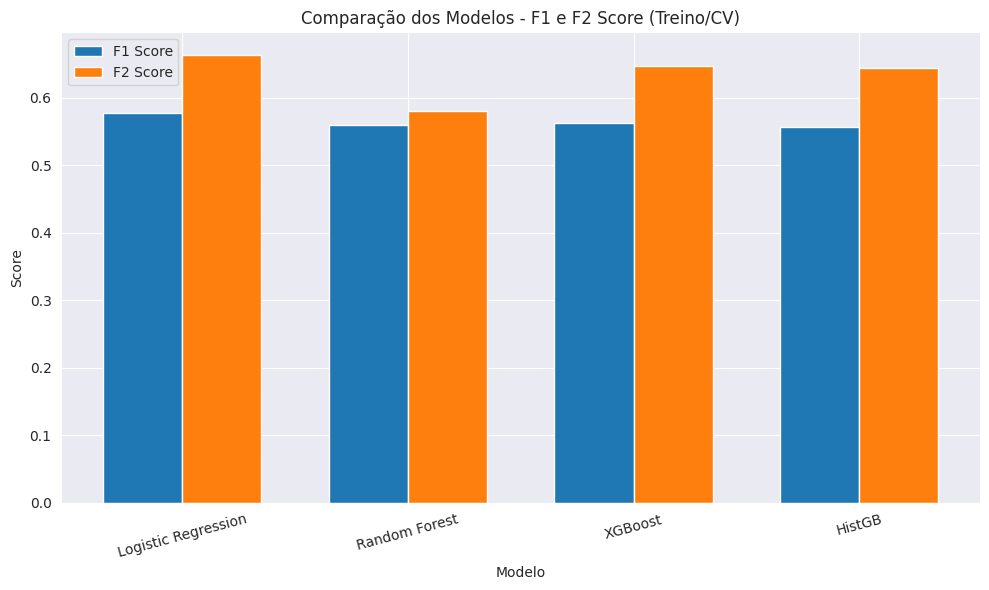

In [34]:

# Converter resultados em DataFrame
resultados_df = pd.DataFrame(resultados)

# Encontrar o melhor modelo pelo maior F2 Score
idx_best = resultados_df['Melhor F2 (Treino/CV)'].idxmax()
melhor_modelo = resultados_df.loc[idx_best, 'Modelo']
melhores_parametros = resultados_df.loc[idx_best, 'Melhores Parâmetros']

print(f"Melhor modelo: {melhor_modelo}")
print("Melhores parâmetros:")
for k, v in melhores_parametros.items():
    print(f"  {k}: {v}")

# Plotar gráfico de barras agrupadas para F1 e F2 score
plt.figure(figsize=(10,6))
bar_width = 0.35
index = range(len(resultados_df))

plt.bar(index, resultados_df['Melhor F1 (Treino/CV)'], bar_width, label='F1 Score')
plt.bar([i + bar_width for i in index], resultados_df['Melhor F2 (Treino/CV)'], bar_width, label='F2 Score')

plt.xlabel('Modelo')
plt.ylabel('Score')
plt.title('Comparação dos Modelos - F1 e F2 Score (Treino/CV)')
plt.xticks([i + bar_width/2 for i in index], resultados_df['Modelo'], rotation=15)
plt.legend()
plt.tight_layout()
plt.show()

Através desta visualização, podemos perceber que o modelo de Regressão Logística foi o que teve melhor performance. Considerando que escolhemos o f2 como nosso principal parâmetro de comparação, tivemos um bom resultado inicial. Assim, vamos continuar para o ajuste de limiar.

6. Analisando a importância de cada variável dentro do modelo

Antes do ajuste de limiar, vamos apenas verificar a importância de cada variável.

In [39]:
melhor_pipe = melhores_modelos['Logistic Regression']
modelo = melhor_pipe.named_steps['classifier']
features = X_train.columns

# Criar um DataFrame de importância
importancia = pd.DataFrame({'feature': features, 'Coeficiente': modelo.coef_[0]}).sort_values(by='Coeficiente', ascending=False)

print(importancia)

                     feature  Coeficiente
9       log_valor_emprestimo     0.632628
5    parcela_mensal_estimada     0.614359
7         cobertura_liquidez     0.427362
3               moradia_rent     0.278784
1                prazo_meses     0.251015
2                moradia_own    -0.029881
0                      idade    -0.076632
6         renda_livre_mensal    -0.597520
4      comprometimento_renda    -1.058342
10  log_valor_conta_corrente   -14.248101
8     is_conta_corrente_zero   -15.615188


Podemos ver que todas as variáveis são significativamente relevantes. Com isso, não iremos remover variáveis que poderiam causar ruído e vamos usar o Ajuste de Limiar.

7. Ajuste de Limiar (Threshold Tuning)

O Ajuste de Limiar é o processo de encontrar o ponto de corte ideal para converter as probabilidades geradas por um modelo de Machine Learning em uma classificação final (como "Inadimplente" ou "Bom Pagador").

O modelo não diz diretamente "Sim" ou "Não"; ele calcula uma probabilidade de, por exemplo, 65% de um cliente ser inadimplente. O Threshold Tuning é a regra de negócio que define a partir de qual porcentagem você tomará uma ação.

Por padrão, os modelos utilizam uma porcentagem de 50% (0.5). Vamos testar qual limiar otimizado nos fará alcançar o maior valor do F1-score.

In [46]:
# 1. Pegar probabilidades do melhor modelo
y_probs = melhores_modelos['Logistic Regression'].predict_proba(X_test)[:, 1]

y_pred_f2 = (y_probs >= best_thr_f2).astype(int)

# 2. Calcular Precisão e Recall para todos os limiares
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# 3. Calcular F1 para cada ponto
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
f2_scores = (1 + 2**2) * (precisions * recalls)/ (2**2 * precisions + recalls + 1e-10)

# 4. Encontrar o melhor limiar
idx_f1 = np.argmax(f1_scores[:-1])
idx_f2 = np.argmax(f2_scores[:-1])

best_thr_f1 = thresholds[idx_f1]
best_thr_f2 = thresholds[idx_f2]

print(f"Melhor Limiar Encontrado: {best_threshold:.4f}")
print(f"F1-Score Final Otimizado: {best_f1:.4f}")
print(f"F2-Score Final Otimizado: {best_f2:.4f}")

print("=== Relatório de Classificação: Otimizado para F2 ===")
print(classification_report(y_test, y_pred_f2))


Melhor Limiar Encontrado: 0.6046
F1-Score Final Otimizado: 0.6412
F2-Score Final Otimizado: 0.6752
=== Relatório de Classificação: Otimizado para F2 ===
              precision    recall  f1-score   support

           0       0.91      0.64      0.75       140
           1       0.50      0.85      0.63        60

    accuracy                           0.70       200
   macro avg       0.70      0.74      0.69       200
weighted avg       0.79      0.70      0.71       200



Com estes resultados, podemos concluir o notebook de machine learning. Conseguimos obter um recall de 85% para clientes considerados arriscados, um f2 score de 0.67 para nosso modelo e um f1 score de 0.64 (a média do mercado para este tipo de problema é 0.6)

Além disso, ao compararmos este notebook com o notebook 03, nosso melhor f1 saiu de 0.58 para 0.64 e o f1 do modelo de logistic regression aumentou de 0.46 para 0.64.

8. Exportando o modelo

Para finalizar e preparar o modelo para as próximas etapas do projeto, vamos usar a biblioteca joblib para definir o que queremos levar para a produção.

In [47]:
dados_saida = {
    'modelo': melhores_modelos['Logistic Regression'], # melhor pipeline
    'features': X_train.columns.tolist(),              # ordem das colunas
    'threshold_f2': best_thr_f2,                       # limiar que foi otimizado
    'metricas': {
        'f2_score': 0.6752,
        'tipo_modelo': 'Regressão Logística'           # metricas do modelo
    }
}

file_name = '../modelos/modelo_credito_final.joblib'
joblib.dump(dados_saida, file_name)

print(f"Modelo exportado para {file_name}")


Modelo exportado para modelo_credito_final.joblib
